## Gaussian Process Regression wit GPy

In [1]:
import numpy as np
import pandas as pd

### 1. Read the data

In [2]:
all_positions = pd.read_csv('../data/positions_xyz_2024-02-27_11h29m.csv', delimiter=',')
all_positions

,x,y,z
0,7.140000,3.070000,15.00000
1,10.140000,3.070000,15.00000
2,10.140000,3.070000,15.00000
3,10.140000,3.070000,15.00000
4,10.138330,3.169981,15.09998
...,...,...,...
500,5.179743,0.799010,12.72901
501,5.256516,0.734943,12.66494
502,5.335387,0.673466,12.60347
503,5.416258,0.614656,12.54466


In [3]:
all_red_ball_positions = pd.read_csv('../data/red_ball_coordinates_128px_2024-02-27_11h29m.csv', delimiter=',')

all_red_ball_positions

,u0,v0,u1,v1,u2,v2,u3,v3,u4,v4,u5,v5,u6,v6
0,0.400000,41.800000,86.846154,39.269231,NaN,NaN,36.387097,80.064516,85.000000,81.518519,NaN,NaN,68.600,121.600000
1,0.500000,42.500000,86.857143,40.214286,NaN,NaN,38.360000,81.800000,85.285714,82.523810,NaN,NaN,68.500,120.166667
2,0.500000,43.500000,87.000000,41.407407,NaN,NaN,38.043478,82.434783,85.875000,83.541667,NaN,NaN,68.500,120.166667
3,1.000000,44.846154,87.291667,41.833333,NaN,NaN,37.636364,82.954545,85.681818,84.227273,NaN,NaN,68.500,120.166667
4,1.166667,45.444444,87.476190,43.238095,NaN,NaN,38.680000,83.920000,86.440000,85.080000,NaN,NaN,68.500,120.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,67.750000,10.500000,57.555556,35.000000,63.880952,59.071429,93.311475,60.836066,59.750000,69.250000,54.480769,104.576923,68.375,119.125000
497,66.957447,8.957447,57.555556,35.000000,63.200000,57.700000,89.754386,60.315789,59.750000,69.250000,53.672727,103.509091,68.375,119.125000
498,65.697674,10.186047,57.555556,35.000000,62.487805,57.048780,91.633333,59.216667,59.750000,69.250000,53.260000,102.500000,68.375,119.125000
499,64.770833,5.062500,57.555556,35.000000,61.000000,54.769231,89.706897,57.603448,59.750000,69.250000,51.529412,100.882353,68.375,119.125000


In [4]:
all_positions = all_positions.iloc[4:]
all_positions.reset_index(drop=True, inplace=True)
all_red_ball_positions.shape,  all_positions.shape

((501, 14), (501, 3))

In [5]:
# Assuming all_red_ball_positions and all_positions are your DataFrames
combined_data = pd.concat([all_red_ball_positions, all_positions], axis=1)

# Remove all rows with 6 or more missing values not with thresh
#combined_data = combined_data.dropna(thresh=combined_data.shape[1]-7)
combined_data

,u0,v0,u1,v1,u2,v2,u3,v3,u4,v4,u5,v5,u6,v6,x,y,z
0,0.400000,41.800000,86.846154,39.269231,NaN,NaN,36.387097,80.064516,85.000000,81.518519,NaN,NaN,68.600,121.600000,10.138330,3.169981,15.09998
1,0.500000,42.500000,86.857143,40.214286,NaN,NaN,38.360000,81.800000,85.285714,82.523810,NaN,NaN,68.500,120.166667,10.133340,3.269852,15.19985
2,0.500000,43.500000,87.000000,41.407407,NaN,NaN,38.043478,82.434783,85.875000,83.541667,NaN,NaN,68.500,120.166667,10.125010,3.369500,15.29950
3,1.000000,44.846154,87.291667,41.833333,NaN,NaN,37.636364,82.954545,85.681818,84.227273,NaN,NaN,68.500,120.166667,10.113370,3.468816,15.39882
4,1.166667,45.444444,87.476190,43.238095,NaN,NaN,38.680000,83.920000,86.440000,85.080000,NaN,NaN,68.500,120.166667,10.098430,3.567688,15.49769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,67.750000,10.500000,57.555556,35.000000,63.880952,59.071429,93.311475,60.836066,59.750000,69.250000,54.480769,104.576923,68.375,119.125000,5.179743,0.799010,12.72901
497,66.957447,8.957447,57.555556,35.000000,63.200000,57.700000,89.754386,60.315789,59.750000,69.250000,53.672727,103.509091,68.375,119.125000,5.256516,0.734943,12.66494
498,65.697674,10.186047,57.555556,35.000000,62.487805,57.048780,91.633333,59.216667,59.750000,69.250000,53.260000,102.500000,68.375,119.125000,5.335387,0.673466,12.60347
499,64.770833,5.062500,57.555556,35.000000,61.000000,54.769231,89.706897,57.603448,59.750000,69.250000,51.529412,100.882353,68.375,119.125000,5.416258,0.614656,12.54466


In [6]:
all_red_ball_positions = combined_data.iloc[:, :14]
all_positions = combined_data.iloc[:, 14:]
all_red_ball_positions.shape, all_positions.shape

((501, 14), (501, 3))

### 2. Handle Missing Values

In [7]:
from sklearn.impute import SimpleImputer, KNNImputer

imputer_mean = SimpleImputer(strategy='mean')
imputer_knn = KNNImputer(n_neighbors=2)
X_all = imputer_knn.fit_transform(all_red_ball_positions)
y_all = imputer_knn.fit_transform(all_positions)
X_all.shape, y_all.shape

((501, 14), (501, 3))

### 3. Prepare the Data

In [8]:
total_samples = len(X_all)
train_samples = int(0.8 * total_samples)

# Split the data
X_train = X_all[:train_samples]
y_train = y_all[:train_samples]

X_test = X_all[train_samples:]
y_test = y_all[train_samples:]

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400, 14), (101, 14), (400, 3), (101, 3))

In [10]:
from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_scaled_train = scaler_x.fit_transform(X_train)
y_scaled_train = y_train

### 4. Train the Model

In [11]:
from GPy.kern import RBF
from GPy.models import GPRegression

#### 4.1 Train GP Regression Model with GPy
For normal regression tasks

In [12]:
kernel = RBF(input_dim=14)
model = GPRegression(X_scaled_train, y_scaled_train, kernel=kernel)
model.optimize(messages=True)

In [13]:
model

GP_regression.,value,constraints,priors
rbf.variance,27.652817958450274,+ve,
rbf.lengthscale,6.759255382286271,+ve,
Gaussian_noise.variance,0.00022520923669541886,+ve,


#### 4.2 Train Sparse GP Regression Model with GPy
Model for large datasets

In [14]:
from GPy.models import SparseGPRegression

kernel = RBF(input_dim=14)
model_sparse = SparseGPRegression(X_scaled_train, y_scaled_train, kernel=kernel)
model_sparse.optimize(messages=True)

In [15]:
model_sparse

sparse_gp.,value,constraints,priors
inducing inputs,"(10, 14)",,
rbf.variance,6.879932972440436,+ve,
rbf.lengthscale,15.16879989765389,+ve,
Gaussian_noise.variance,0.030142353261843464,+ve,


### 5. Make Predictions

In [16]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

X_scaled_test = scaler_x.transform(X_test)

#### 5.1 Predict with GP Regression Model

In [17]:
y_pred_reg, y_var_reg = model.predict(X_scaled_test)
y_pred_reg = y_pred_reg
y_pred_reg

array([[ 9.18491737,  5.31296697, 17.24204282],
       [ 9.11276886,  5.34859802, 17.27996248],
       [ 9.11156939,  5.34463754, 17.27164809],
       [ 9.02477988,  5.38264567, 17.31075347],
       [ 8.9330389 ,  5.47606476, 17.4036864 ],
       [ 8.8579183 ,  5.5167319 , 17.44420876],
       [ 8.7823294 ,  5.56528761, 17.49119776],
       [ 8.70381353,  5.65447237, 17.58191539],
       [ 8.61953846,  5.68809888, 17.61276725],
       [ 8.52399415,  5.71566523, 17.64770133],
       [ 8.4293045 ,  5.74983627, 17.68303462],
       [ 8.35881572,  5.78696686, 17.7194928 ],
       [ 8.25219893,  5.82369951, 17.75547879],
       [ 8.18957203,  5.85385907, 17.78300288],
       [ 7.98652548,  5.9417264 , 17.87339798],
       [ 7.91782391,  5.97205494, 17.90101816],
       [ 7.79599904,  5.99939789, 17.93108636],
       [ 7.70946743,  6.01995532, 17.95084101],
       [ 7.64285104,  6.00838994, 17.93680327],
       [ 7.52732473,  6.02715011, 17.95659405],
       [ 7.45112144,  6.06601133, 17.992

#### 5.2 Predict with Sparse GP Regression Model

In [18]:
y_pred_sparse, y_var_sparse = model_sparse.predict(X_scaled_test)
y_pred_sparse = y_pred_sparse
y_pred_sparse

array([[ 9.21554356,  5.07720156, 17.01719898],
       [ 9.15655698,  5.11450801, 17.05765955],
       [ 9.14229622,  5.10172683, 17.05887382],
       [ 9.05853842,  5.13822101, 17.10099925],
       [ 8.92221584,  5.32995937, 17.28928433],
       [ 8.86424695,  5.3992297 , 17.3546211 ],
       [ 8.75364677,  5.47531934, 17.43784242],
       [ 8.52142477,  5.61766663, 17.64641531],
       [ 8.72407603,  5.44418072, 17.41058887],
       [ 8.40769364,  5.69633805, 17.71553489],
       [ 8.37595431,  5.68130463, 17.7039037 ],
       [ 8.27837349,  5.75605204, 17.7801184 ],
       [ 8.18072629,  5.8043775 , 17.83450855],
       [ 8.17822613,  5.73295783, 17.77013602],
       [ 7.75649355,  5.87166985, 17.85388187],
       [ 7.77155469,  5.83952168, 17.82170492],
       [ 7.67450751,  5.88193634, 17.86599138],
       [ 7.56793474,  5.98372144, 17.95800992],
       [ 7.61132739,  5.91272669, 17.8840561 ],
       [ 7.47843095,  5.97242987, 17.9362539 ],
       [ 7.40603047,  6.02801055, 17.990

### 6. Evaluate the Model

In [19]:
def evaluate_model(y_test_evaluate, y_pred_evaluate):
    mse = mean_squared_error(y_test_evaluate, y_pred_evaluate)
    r2 = r2_score(y_test_evaluate, y_pred_evaluate)
    mae = mean_absolute_error(y_test_evaluate, y_pred_evaluate)
    return mse, r2, mae


#### 6.1 Evaluate GP Regression Model

In [20]:
y_test

array([[ 9.229481 ,  5.222689 , 17.15269  ],
       [ 9.156578 ,  5.291129 , 17.22113  ],
       [ 9.081432 ,  5.357102 , 17.2871   ],
       [ 9.004133 ,  5.420534 , 17.35053  ],
       [ 8.92476  ,  5.481355 , 17.41135  ],
       [ 8.843406 ,  5.539495 , 17.4695   ],
       [ 8.760157 ,  5.594894 , 17.52489  ],
       [ 8.675111 ,  5.647486 , 17.57749  ],
       [ 8.588357 ,  5.697216 , 17.62722  ],
       [ 8.499996 ,  5.744025 , 17.67402  ],
       [ 8.410121 ,  5.787865 , 17.71786  ],
       [ 8.318838 ,  5.828684 , 17.75868  ],
       [ 8.226243 ,  5.86644  , 17.79644  ],
       [ 8.132442 ,  5.901088 , 17.83109  ],
       [ 8.037539 ,  5.93259  , 17.86259  ],
       [ 7.941638 ,  5.960913 , 17.89091  ],
       [ 7.844848 ,  5.986023 , 17.91602  ],
       [ 7.747272 ,  6.007894 , 17.93789  ],
       [ 7.649024 ,  6.0265   , 17.9565   ],
       [ 7.550209 ,  6.041822 , 17.97182  ],
       [ 7.45094  ,  6.053843 , 17.98384  ],
       [ 7.351323 ,  6.062548 , 17.99255  ],
       [ 7

In [21]:
mse_reg, r2_reg, mae_reg = evaluate_model(y_test, y_pred_reg)
print("MSE:", mse_reg)
print("R2:", r2_reg)
print("MAE:", mae_reg)

MSE: 0.004512161075635127
R2: 0.9983683038505071
MAE: 0.024963681288839867


#### 6.2 Evaluate Sparse GP Regression Model

In [22]:
mse_sparse, r2_sparse, mae_sparse = evaluate_model(y_test, y_pred_sparse)
print("MSE:", mse_sparse)
print("R2:", r2_sparse)
print("MAE:", mae_sparse)

MSE: 0.017364415814837064
R2: 0.9942928128978071
MAE: 0.09685881808042834


### 7. Visualize results

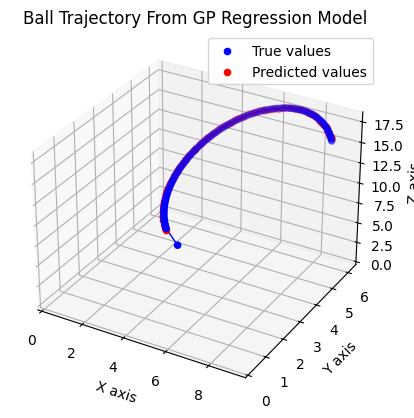

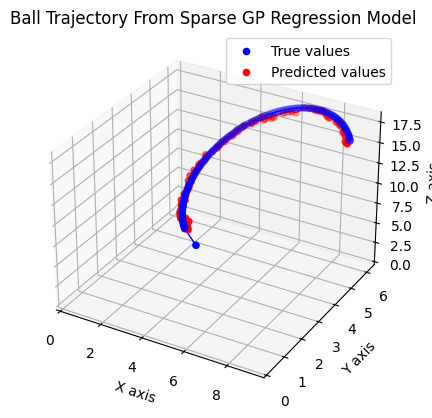

In [24]:
from utils.plot_maker_gaussian_process import plot_maker_3d

plot_maker_3d(y_test, y_pred_reg, "Ball Trajectory From GP Regression Model")
plot_maker_3d(y_test, y_pred_sparse, "Ball Trajectory From Sparse GP Regression Model")

In [30]:
# let this model make predictions on new data
new_red_ball = pd.read_csv('../data/red_ball_coordinates_128px_2024-02-27_11h24m.csv', delimiter=',')
new_positions = pd.read_csv('../data/positions_xyz_2024-02-27_11h24m.csv', delimiter=',')
new_combined_data = pd.concat([new_red_ball, new_positions], axis=1)
new_combined_data = new_combined_data.dropna(thresh=new_combined_data.shape[1]-3)
new_red_ball = new_combined_data.iloc[:, :14]
new_positions = new_combined_data.iloc[:, 14:]
new_red_ball.shape, new_positions.shape

((486, 14), (486, 3))

In [31]:
scaler_x = StandardScaler()

imputer_knn = KNNImputer(n_neighbors=2)
new_red_ball_imputed = imputer_knn.fit_transform(new_red_ball)
new_positions_imputed = imputer_knn.fit_transform(new_positions)
X_scaled_new = scaler_x.fit_transform(new_red_ball_imputed)

In [36]:
y_pred_new_reg, _ = model.predict(np.array(X_scaled_new))
y_pred_new_reg

IndexError: index 12 is out of bounds for axis 1 with size 12

In [33]:
mse_new_reg, r2_new_reg, mae_new_reg = evaluate_model(new_positions_imputed, y_pred_new_reg)
print("MSE:", mse_new_reg)
print("R2:", r2_new_reg)
print("MAE:", mae_new_reg)

NameError: name 'y_pred_new_reg' is not defined